# 1.0 Clustering Basic

### Check the Manual on Clustering of scikit https://scikit-learn.org/stable/modules/clustering.html

## 1.1 Introduction



The following two sections are available at: https://github.com/ivanovitchm/IMD1101_Machine_Learning/blob/master/Lesson22/Lesson%2022%20-%20%20Clustering.ipynb


So far, we've looked at regression and classification. These are both types of [supervised machine learning](https://en.wikipedia.org/wiki/Supervised_learning). In supervised learning, you train an algorithm to predict an unknown variable from known variables.

Another major type of machine learning is called [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning). In unsupervised learning, we aren't trying to predict anything. Instead, we're finding patterns in data.

One of the main unsupervised learning techniques is called **clustering**. We use clustering when we're trying to explore a dataset, and understand the connections between the various rows and columns. For example, we can cluster NBA players based on their statistics.


**The clusters made it possible to discover player roles that might not have been noticed otherwise**. [Here's](https://flowingdata.com/2012/03/21/redefining-nba-basketball-positions/) an article that describes how the clusters were created.

Clustering algorithms group similar rows together. There can be one or more groups in the data, and these groups form the clusters. As we look at the clusters, we can start to better understand the structure of the data.

Clustering is a key way to explore unknown data, and it's a very commonly used machine learning technique. In this lesson we'll work on **clustering US Senators based on how they voted.**

## 1.1 The dataset




In the US, the **Senate votes on proposed legislation**. Getting a bill passed by the Senate is a key step towards getting its provisions enacted. A **majority vote is required** to get a bill passed.

The results of these votes, known as roll call votes, are public, and available in a few places, including [here](https://github.com/unitedstates/congress). Read more about the US legislative system [here](https://en.wikipedia.org/wiki/Federal_government_of_the_United_States#Legislative_branch).

**Senators typically vote in accordance with how their political party votes**, known as voting along party lines. In the US, the 2 main political parties are the [Democrats](https://en.wikipedia.org/wiki/Democratic_Party), who tend to be [liberal](https://en.wikipedia.org/wiki/Liberalism), and the [Republicans](https://en.wikipedia.org/wiki/Republican_Party), who tend to be [conservative](https://en.wikipedia.org/wiki/Conservatism). **Senators** can also choose to be unaffiliated with a party, and vote as **Independents**, although very few choose to do so.

**114_congress.csv** contains all of the results of roll call votes from the **114th Senate**. Each row represents a single Senator, and each column represents a vote. A 0 in a cell means the Senator voted No on the bill, 1 means the Senator voted Yes, and 0.5 means the Senator abstained.

Here are the relevant columns:

- **name** -- The last name of the Senator.
- **party** -- the party of the Senator. The valid values are __D__ for Democrat, __R__ for Republican, and __I__ for Independent.
- Several columns numbered like **00001**, **00004**, etc. Each of these columns represents the results of a single roll call vote.

Below are the first three rows of the data. As you can see, the number of each bill is used as the column heading for its votes:

```python
name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
Alexander,R,TN,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0
Ayotte,R,NH,0,1,1,1,1,0,0,1,0,1,0,1,0,1,0
```

**Clustering voting data of Senators is particularly interesting because it can expose patterns that go deeper than party affiliation**. For example, some Republicans are more liberal than the rest of their party. Looking at voting data can help us discover the Senators who are more or less in the mainstream of their party.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Import the Pandas library.
- Use the **read_csv()** method in Pandas to read **114_congress.csv** into the variable **votes**.


In [ ]:
# Uploading files from your local file system
# AmesHousing.txt

#from google.colab import files

#uploaded = files.upload()

#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))



In [ ]:
# put your code here
import pandas as pd
votes = pd.read_csv('https://raw.githubusercontent.com/colby-schrauth/DataScience/master/114_congress.csv')

## 1.2 Exploring the data

Now that we've read the data in, let's do some initial exploration of the data.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Find how many Senators are in each party.
  - Use the **value_counts()** method on the **party** column of **votes**. Print the results.
- Find what the "average" vote for each bill was.
  - Use the **mean()** method on the **votes** Dataframe. If the mean for a column is less than .5, more Senators voted against the bill, and vice versa if it's over .5. Print the results.


In [ ]:
# put your code here

print(votes['party'].value_counts())

print(votes.mean())

R    54
D    44
I     2
Name: party, dtype: int64
00001    0.325
00004    0.575
00005    0.535
00006    0.945
00007    0.545
00008    0.415
00009    0.545
00010    0.985
00020    0.525
00026    0.545
00032    0.410
00038    0.480
00039    0.510
00044    0.460
00047    0.370
dtype: float64


<ipython-input-5-1ba6632cddae>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(votes.mean())


## 1.3 Distance between Senators


To group Senators together, we need some way to figure out how "close" the Senators are to each other. **We'll then group together the Senators that are the closest**. We can actually discover this distance mathematically, by finding how similar the votes of two Senators are. The closer together the voting records of two Senators, the more ideologically similar they are (voting the same way indicates that you share the same views).

To find the distance between two rows, we can use [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). The formula is:

$$d=\sqrt{(q_1-p_1)^2+(q_2-p_2)^2+\ldots+(q_n-p_n)^2}$$

Let's say we have two Senator's voting records:

```python
name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
Alexander,R,TN,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0
Ayotte,R,NH,0,1,1,1,1,0,0,1,0,1,0,1,0,1,0
```

If we took only the numeric vote columns, we'd have this:

```python
00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
0,1,1,1,1,0,0,1,1,1,0,0,0,0,0
0,1,1,1,1,0,0,1,0,1,0,1,0,1,0
```

If we wanted to compute the Euclidean distance, we'd plug the vote numbers into our formula:

$$d=\sqrt{(0-0)^2+(1-1)^2+(1-1)^2+(1-1)^2+(1-1)^2+(0-0)^2+\ldots+(0-0)^2}$$

As you can see, these Senators are very similar! If you look at the votes above, they only disagree on 3 bills. The final Euclidean distance between these two Senators is **1.73**.

To compute Euclidean distance in Python, we can use the [euclidean_distances()](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html) method in the [scikit-learn](http://scikit-learn.org/stable/) library. The code below will find the Euclidean distance between the Senator in the first row and the Senator in the second row.

```python
euclidean_distances(votes.iloc[0,3:], votes.iloc[1,3:])
```

It's necessary to only select columns after the first 3 because the first 3 are name, party, and state, which aren't numeric.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Compute the **Euclidean distance** between the **first row** and the **third row**.
  - Assign the result to **distance**.
  - tip: use series.values.reshape(1,-1) in euclidean_distance parameters

In [ ]:
# put your code here
from sklearn.metrics.pairwise import euclidean_distances
distance = euclidean_distances(votes.iloc[0,3:].values.reshape(1,-1),
                               votes.iloc[1,3:].values.reshape(1,-1))

## 1.4 Initial clustering




We'll use an algorithm called [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to split our data into clusters. k-means clustering uses Euclidean distance to form clusters of similar Senators. We'll dive more into the theory of k-means clustering and build the algorithm from the ground up in the later section. For now, it's important to understand clustering at a high level, so we'll leverage the [scikit-learn](http://scikit-learn.org/stable/) library to train a **k-means model.**

The **k-means** algorithm will **group Senators who vote similarly** on bills together, in clusters. Each cluster is assigned a center, and the Euclidean distance from each Senator to the center is computed. Senators are assigned to clusters based on which one they are closest to. **From our background knowledge, we think that Senators will cluster along party lines**.

The k-means algorithm requires us to specify the number of clusters upfront. Because we suspect that clusters will occur along party lines, and the vast majority of Senators are either Republicans or Democrats, we'll pick 2 for our number of clusters.

We'll use the [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class from scikit-learn to perform the clustering. **Because we aren't predicting anything, there's no risk of overfitting, so we'll train our model on the whole dataset.** After training, we'll be able to extract cluster labels that indicate what cluster each Senator belongs to.

We can initialize the model like this:

```python
kmeans_model = KMeans(n_clusters=2, random_state=1)
```

The above code will initialize the k-means model with 2 clusters, and a random state of 1 to allow for the same results to be reproduced whenever the algorithm is run.

We'll then be able to use the [fit_transform()](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_transform) method to fit the model to **votes** and get the distance of each Senator to each cluster. The result will look like this:

```python
array([[ 3.12141628,  1.3134775 ],
   [ 2.6146248 ,  2.05339992],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 1.43833966,  2.96866004],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.31287498,  3.30758755],
   ...
```

This is a NumPy array with two columns. The first column is the Euclidean distance from each Senator to the first cluster, and the second column is the Euclidean distance to the the second cluster. The values in the columns will indicate how "far" the Senator is from each cluster. The further away from the cluster, the less the Senator's voting history aligns with the voting history of the cluster.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Use the **fit_transform()** method to fit **kmeans_model** on the **votes** DataFrame. Only select columns after the first 3 from **votes** when fitting.
- Assign the result to **senator_distances.**

In [ ]:
# put your code here'
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=1)
senator_distances = kmeans_model.fit_transform(votes.iloc[:,3:])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## 1.5. Exploring the clusters




We can use the Pandas method [crosstab()](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.crosstab.html) to compute and display how many Senators from each party ended up in each cluster. The **crosstab()** method takes in two vectors or Pandas Series and computes how many times each unique value in the second vector occurs for each unique value in the first vector.

Here's an example:

```python
is_smoker =       [0,1,1,0,0,1]
has_lung_cancer = [1,0,1,0,1,0]

pd.crosstab(np.array(has_lung_cancer),np.array(is_smoker),
          colnames=["has_lung_cancer"],rownames=["is_smoker"])

```

A 0 means False, and a 1 means True. A crosstab for the two above lists would look like this:

```python
has_lung_cancer    0     1
smoker
0                  1     2
1                  2     1
```

We can extract the cluster labels for each Senator from **kmeans_model** using **kmeans_model.labels_**, then we can make a table comparing these labels to **votes["party"]** with crosstab(). This will show us if the clusters tend to break down along party lines or not.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Use the **labels_** attribute to extract the labels from **kmeans_model**. Assign the result to the variable **labels**.
- Use the **crosstab()** method to print out a table comparing labels to **votes["party"]**, in that order.

In [ ]:
# put your code here

labels = kmeans_model.labels_
print(labels)
print(pd.crosstab(labels, votes["party"]))

[1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1
 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0
 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0]
party   D  I   R
row_0           
0      41  2   0
1       3  0  54


## 1.6. Exploring Senators in the wrong cluster




It looks like both of our clusters mostly broke down along party lines. The first cluster contains **41** Democrats, and **two** Independents. The second cluster contains **3** Democrats, and **54** Republicans.

No Republicans seem to have broken party ranks to vote with the Democrats, but **3** Democrats are more similar to Republicans in their voting than their own party. Let's explore these **3** in more depth so we can figure out why that is.

We can do this by subsetting votes to only select rows where the party column is **D**, and the labels variable is **1**, indicating that the Senator is in the second cluster.

We can perform this subsetting with Pandas. The below code will select all Independents in the first cluster:

```python
votes[(labels == 0) & (votes["party"] == "I")]
```

When subsetting a DataFrame with multiple conditions, each condition needs to be in parentheses, and separated by **&**.

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Select all senators who were assigned to the second cluster that were Democrats. Assign the subset to **democratic_outliers**.
- Print out **democratic_outliers.**

In [ ]:
#put your code here
democratic_outliers = votes[(labels == 0) & (votes["party"] == "I")]
print(democratic_outliers)

       name party state  00001  00004  00005  00006  00007  00008  00009  \
50     King     I    ME    0.0    0.0    0.0    1.0    0.0    1.0    0.0   
79  Sanders     I    VT    1.0    0.0    0.0    1.0    0.0    1.0    0.0   

    00010  00020  00026  00032  00038  00039  00044  00047  
50    1.0    0.0    0.0    1.0    1.0    0.0    1.0    1.0  
79    1.0    0.0    0.0    1.0    1.0    0.0    1.0    1.0  


## 1.7 Plotting out the clusters

One great way to explore clusters is to visualize them using **matplotlib**. Earlier, we computed a **senator_distances** array that shows the distance from each Senator to the center of each cluster. We can treat these distances as x and y coordinates, and make a scatterplot that shows the position of each Senator. This works because the distances are relative to the cluster centers.

While making the scatterplot, we can also shade each point according to party affiliation. This will enable us to quickly look at the layout of the Senators, and see who crosses party lines.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Make a scatterplot using [plt.scatter()](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter). Pass in the following keyword arguments:
  - **x** should be the first column of **senator_distances.**
  - **y** should be the second column of **senator_distances.**
  - **c** should be **labels**. This will shade the points according to label.
  - **cmap** should be set to "RdBu"
- Use **plt.show()** to show the plot.

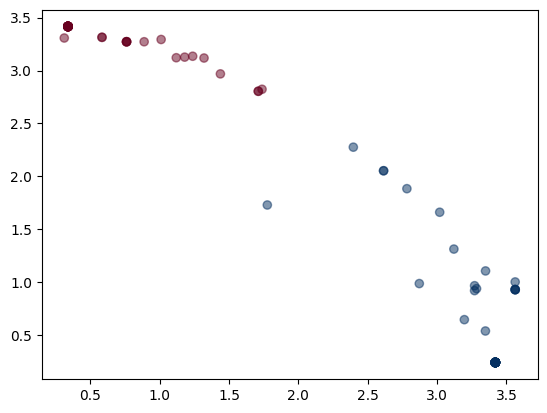

In [ ]:
# put your code here
import matplotlib.pyplot as plt


plt.scatter(senator_distances[:,0], senator_distances[:,1], alpha=0.5, c=labels, cmap="RdBu")
plt.show()

## 1.8 Finding the most extreme




The **most extreme** Senators are those who are the furthest away from one cluster. For example, a radical Republican would be as far from the Democratic cluster as possible. Senators who are in between both clusters are more moderate, as they fall in between the views of the two parties.

If we look at the first few rows of **senator_distances**, we can start to see who is more extreme:

>```python
[
       [ 3.12141628,  1.3134775 ], # Slightly moderate, far from cluster 1, close to cluster 2.
       [ 2.6146248 ,  2.05339992], # Moderate, far from cluster 1, far from cluster 2.
       [ 0.33960656,  3.41651746], # Somewhat extreme, very close to cluster 1, very far from cluster 2.
       [ 3.42004795,  0.24198446], # Fairly extreme, very far from cluster 1, very close to cluster 2.
       ...
   ]
```

We'll create a formula to find extremists -- we'll cube the distances in both columns of **senator_distances**, then add them together. The higher the exponent we raise a set of numbers to, the more separation we'll see between small values and low values. For instance, squaring [1,2,3] results in [1,4,9], and cubing it results in [1,8,27].

We cube the distances so that we can get a good amount of separation between the extremists who are farther away from a party, who have distances that look like extremist = [3.4, .24], and moderates, whose distances look like moderate = [2.6, 2]. If we left the distances as is, we'd end up with 3.4 + .24 = 3.64, and 2.6 + 2 = 4.6, which would make the moderate, who is between both parties, seem extreme. If we cube, we instead end up with $3.4^ 3 + .24^3 = 39.3$, and $2.6^3 + 2^3 = 25.5$, which correctly identifies the extremist.

Here's how the first few ratings would look:

```python
[
       [ 3.12141628,  1.3134775 ], # 32.67
       [ 2.6146248 ,  2.05339992], # 26.5
       [ 0.33960656,  3.41651746], # 39.9
       [ 3.42004795,  0.24198446], # 40
       ...
   ]
```

We can cube every value in **senator_distances** by typing $senator\_distances^3$. To find the sum across every row, we'll need to use the NumPy [sum()](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html) method, and pass in the keyword argument axis=1.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">



- Compute an extremism rating by cubing every value in **senator_distances**, then finding the **sum** across each row. Assign the result to **extremism.**
- Assign the **extremism** variable to the **extremism** column of **votes**.
- Sort **votes** on the **extremism** column, in **descending** order, using the **sort_values()** method on DataFrames.
- Print the top 10 most extreme Senators.

In [ ]:
# put your code here

extremism = senator_distances[:,0]**3 + senator_distances[:,1]**3
votes["extremism"] = extremism
votes = votes.sort_values(by="extremism", axis=0, ascending=False)
print(votes.head(10))

         name party state  00001  00004  00005  00006  00007  00008  00009  \
98     Wicker     R    MS    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
53   Lankford     R    OK    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
69       Paul     R    KY    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
80      Sasse     R    NE    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
26       Cruz     R    TX    0.0    1.0    1.0    0.0    1.0    0.0    1.0   
48    Johnson     R    WI    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
47    Isakson     R    GA    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
65  Murkowski     R    AK    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
64      Moran     R    KS    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
30       Enzi     R    WY    0.0    1.0    1.0    1.0    1.0    0.0    1.0   

    00010  00020  00026  00032  00038  00039  00044  00047  extremism  
98    0.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0  46.250476

## 1.9 Next steps




**Clustering is a powerful way to explore data and find patterns.** Unsupervised learning is very commonly used with large datasets where it isn't obvious how to start with supervised machine learning. In general, it's a good idea to try unsupervised learning to explore a dataset before trying to use supervised learning machine learning models.

In the next section, we'll dive more into the **k-means** clustering algorithm and build our own from the ground up.



# 2.0 K-means clustering

## 2.1 Clustering NBA Players

In NBA media coverage, sports reporters usually focus on a handful of players and paint stories of how unique these players' stats are. With our data science hats on, we can't help but feel a slight sense of skepticism to how different the players are from one another. Let's see how we can use data science to explore that thread further.

Let's look at the dataset of player performance from the 2013-2014 season.

Here are some selected columns:

- **player** -- name of the player
- **pos** -- the position of the player
- **g** -- number of games the player was in
- **pts** -- total points the player scored
- **fg.** -- field goal percentage
- **ft.** -- free throw percentage

Check out [Database Basketball](https://www.rotowire.com/basketball/stats.php?season=2013) for an explanation of all the columns

In [ ]:
import pandas as pd
import numpy as np

# visualize more columns
pd.set_option('display.max_columns', 50)

nba = pd.read_csv("https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/nba_2013.csv")
nba.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,4,15,0.266667,62,126,0.492063,0.482,35,53,0.660,72,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,0,0,NaN,93,185,0.502703,0.503,79,136,0.581,142,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,0,0,NaN,143,275,0.520000,0.520,76,119,0.639,102,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,128,300,0.426667,336,711,0.472574,0.522,274,336,0.815,32,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,0,1,0.000000,136,248,0.548387,0.546,56,67,0.836,94,183,277,40,23,46,63,187,328,2013-2014,2013


## 2.2 Point Guards


**Point guards** play one of the most crucial roles on a team because their **primary responsibility is to create scoring opportunities** for the team. We are going to focus our lesson on a machine learning technique called **clustering**, which allows us to visualize the types of point guards as well as group similar point guards together. **Using 2 features** allows us to easily visualize the players and will also make it easier to grasp how clustering works. For point guards, it's widely accepted that the **Assist to Turnover Ratio** is a good indicator for performance in games as it quantifies the number of scoring opportunities that player created. Let's also use **Points Per Game**, since effective Point Guards not only set up scoring opportunities but also take a lot of the shots themselves


<center><img width="300" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1TRx73TAAQozxnflLXPhWXuDbM-Q2KHh4"></center>



**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Create a new Dataframe which contains just the point guards from the data set.
  - Point guards are specified as **PG** in the **pos** column.
- Assign the filtered data frame to **point_guards**.


In [ ]:
# put your code here
point_guards = nba[nba['pos'] == 'PG']
point_guards

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,133,332,0.400602,165,386,0.427461,0.508,201,227,0.885,15,115,130,313,53,3,125,147,930,2013-2014,2013
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,7,25,0.280000,49,106,0.462264,0.454,31,39,0.795,5,32,37,32,7,4,19,30,150,2013-2014,2013
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,73,231,0.316017,181,425,0.425882,0.443,79,100,0.790,16,138,154,303,26,0,125,129,660,2013-2014,2013
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,76,212,0.358491,172,405,0.424691,0.464,94,118,0.797,22,123,145,194,60,9,82,161,666,2013-2014,2013
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,79,210,0.376190,54,143,0.377622,0.489,33,43,0.767,13,146,159,307,54,8,102,85,378,2013-2014,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,Russell Westbrook,PG,25,OKC,46,46,1412,346,791,0.437,68,214,0.317757,278,577,0.481802,0.480,242,293,0.826,55,208,263,319,88,7,177,104,1002,2013-2014,2013
462,Deron Williams,PG,29,BRK,64,58,2059,322,716,0.450,98,268,0.365672,224,448,0.500000,0.518,173,216,0.801,15,153,168,392,93,13,143,148,915,2013-2014,2013
465,Louis Williams,PG,27,ATL,60,7,1445,197,493,0.400,79,231,0.341991,118,262,0.450382,0.480,152,179,0.849,10,114,124,210,45,4,92,65,625,2013-2014,2013
467,Mo Williams,PG,31,POR,74,0,1834,280,672,0.417,83,225,0.368889,197,447,0.440716,0.478,78,89,0.876,42,111,153,321,55,10,149,197,721,2013-2014,2013


## 2.3 Points Per Game

While our dataset doesn't come with **Points Per Game** values, we can easily calculate those using each player's total points (**pts**) and the number of games (**g**) they played. Let's take advantage of pandas' ability to multiply and divide columns to create the Points Per Game **ppg** column by dividing the pts and g columns.

In [ ]:
# put your code here df.loc[(df!=0).any(axis=1)]
point_guards = point_guards.loc[(point_guards["g"]!=0)]
point_guards['ppg'] = point_guards['pts'] / point_guards['g']
point_guards


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,x2p,x2pa,x2p.,efg.,ft,fta,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end,ppg
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,133,332,0.400602,165,386,0.427461,0.508,201,227,0.885,15,115,130,313,53,3,125,147,930,2013-2014,2013,13.098592
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,7,25,0.280000,49,106,0.462264,0.454,31,39,0.795,5,32,37,32,7,4,19,30,150,2013-2014,2013,7.500000
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,73,231,0.316017,181,425,0.425882,0.443,79,100,0.790,16,138,154,303,26,0,125,129,660,2013-2014,2013,8.354430
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,76,212,0.358491,172,405,0.424691,0.464,94,118,0.797,22,123,145,194,60,9,82,161,666,2013-2014,2013,9.250000
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,79,210,0.376190,54,143,0.377622,0.489,33,43,0.767,13,146,159,307,54,8,102,85,378,2013-2014,2013,6.872727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,Russell Westbrook,PG,25,OKC,46,46,1412,346,791,0.437,68,214,0.317757,278,577,0.481802,0.480,242,293,0.826,55,208,263,319,88,7,177,104,1002,2013-2014,2013,21.782609
462,Deron Williams,PG,29,BRK,64,58,2059,322,716,0.450,98,268,0.365672,224,448,0.500000,0.518,173,216,0.801,15,153,168,392,93,13,143,148,915,2013-2014,2013,14.296875
465,Louis Williams,PG,27,ATL,60,7,1445,197,493,0.400,79,231,0.341991,118,262,0.450382,0.480,152,179,0.849,10,114,124,210,45,4,92,65,625,2013-2014,2013,10.416667
467,Mo Williams,PG,31,POR,74,0,1834,280,672,0.417,83,225,0.368889,197,447,0.440716,0.478,78,89,0.876,42,111,153,321,55,10,149,197,721,2013-2014,2013,9.743243


## 2.4 Assist Turnover Ratio

Now let's create a column, **atr**, for the Assist Turnover Ratio, which is calculated by dividing total assists (**ast**) by total turnovers (**tov**):

$$
\displaystyle atr = \frac{ast}{tov}
$$

**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">


- Drop the players who have 0 turnovers.
  - Not only did these players only play a few games, making it hard to understand their true abilities, but we also cannot divide by 0 when we calculate **atr**.
- Utilize the same division technique we used with Points Per Game to create the Assist Turnover Ratio (**atr**) column for **point_guards.**

In [ ]:
# put your code here

point_guards = point_guards.loc[(point_guards["tov"]!=0)]
point_guards['atr'] = point_guards['ast']/ point_guards['tov']

<ipython-input-15-ae35303ea7b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_guards['atr'] = point_guards['ast']/ point_guards['tov']


In [ ]:
point_guards['atr']

24     2.504000
29     1.684211
30     2.424000
38     2.365854
50     3.009804
         ...   
459    1.802260
462    2.741259
465    2.282609
467    2.154362
471    3.280702
Name: atr, Length: 82, dtype: float64

## 2.5 Visualizing the Point Guards

Use **matplotlib** to create a **scatter** plot with Points Per Game (**ppg**) on the X axis and Assist Turnover Ratio (**atr**) on the Y axis.


<ipython-input-17-aedd9c50a041>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(point_guards['ppg'], point_guards['atr'], alpha=0.5,  cmap="RdBu")


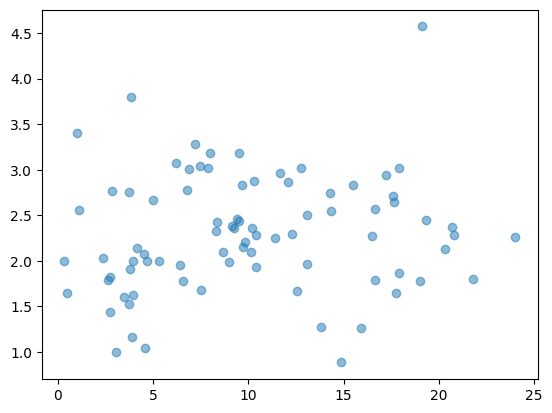

In [ ]:
# put your code here

import matplotlib.pyplot as plt

plt.scatter(point_guards['ppg'], point_guards['atr'], alpha=0.5,  cmap="RdBu")
plt.show()

#point_guards.plot.scatter(x='ppg', y='atr')

## 2.6 Clustering players

**There seem to be 5 general regions**, or clusters, that the point guards fall into (with a few outliers of course!). We can use a technique called clustering to segment all of the point guards into groups of alike players. While regression and other supervised machine learning techniques work well when we have a clear metric we want to optimize for and lots of pre-labelled data, we need to instead use **unsupervised machine learning techniques to explore the structure within a data set that doesn't have a clear value to optimize.**

There are multiple ways of clustering data but here we will focus on **centroid based clustering** for this lesson. Centroid based clustering works well when the clusters resemble circles with centers (or centroids). **The centroid represent the arithmetic mean of all of the data points in that cluster.**

**K-Means Clustering is a popular centroid-based clustering algorithm that we will use.** The K in K-Means refers to the number of clusters we want to segment our data into. The key part with K-Means (and most unsupervised machine learning techniques) is that we have to specify what k is. There are advantages and disadvantages to this, but one advantage is that we can pick the k that makes the most sense for our use case. We'll set k to 5 since we want K-Means to segment our data into 5 clusters.

## 2.7 The Algorithm

Setup K-Means is an iterative algorithm that switches between recalculating the centroid of each cluster and the players that belong to that cluster. **To start, select 5 players at random and assign their coordinates as the initial centroids of the just created clusters.**

- **Step 1 (Assign Points to Clusters)** - for each player, calculate the Euclidean distance between that player's coordinates, or values for **atr & ppg**, and each of the centroids' coordinates. Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.

- **Step 2 (Update New Centroids of the Clusters)** - for each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. We calculate the arithmetic mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

- Iterate Repeat steps 1 & 2 until the clusters are no longer moving and have converged.




In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

point_guards.reset_index(drop=True, inplace=True)
num_clusters = 5

# Use numpy's random function to generate a list,
# length: num_clusters, of indices
np.random.seed(0)
random_initial_points = np.random.choice(point_guards.index, replace=False, size=num_clusters)

# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points,['atr','ppg']]
centroids.reset_index(drop=True, inplace=True)
centroids_prev = point_guards.loc[random_initial_points+1,['atr','ppg']]
centroids_prev.reset_index(drop=True, inplace=True)

point_guards['cluster'] = 0


<ipython-input-18-f0899caa5c98>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_guards['cluster'] = 0


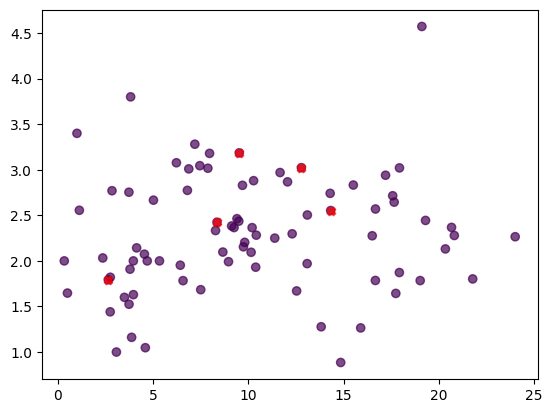

In [ ]:
# Before Update the Centroids!
import matplotlib.pyplot as plt

plt.scatter(point_guards['ppg'], point_guards['atr'], alpha=0.7, c=point_guards['cluster'], label=point_guards['cluster'], cmap="viridis")
plt.scatter(centroids['ppg'], centroids['atr'],  alpha=0.7, marker="X", color="r")

plt.show()

In [ ]:
while ((centroids_prev['atr'] != centroids['atr']).all() & (centroids_prev['ppg'] != centroids['ppg']).all()):
  centroids_prev = centroids
  # STEP 1
  distance = euclidean_distances(point_guards.loc[:,['atr','ppg']], centroids.loc[:,['atr','ppg']])
  j=0
  for i in distance:
    point_guards.loc[j,['cluster']] = np.argmin(i)
    j+=1
  # STEP 2
  for i in range(0,5):
    centroids.loc[i,['atr']] = point_guards.loc[point_guards['cluster']==i]['atr'].mean().round(4)
    centroids.loc[i,['ppg']] = point_guards.loc[point_guards['cluster']==i]['ppg'].mean().round(4)

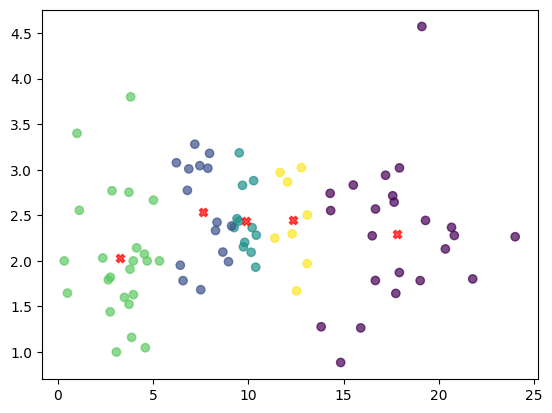

In [ ]:
# After Update the Centroids!
import matplotlib.pyplot as plt

plt.scatter(point_guards['ppg'], point_guards['atr'], alpha=0.7, c=point_guards['cluster'], label=point_guards['cluster'], cmap="viridis")
plt.scatter(centroids['ppg'], centroids['atr'], alpha=0.7, marker="X",color="r")

plt.show()

In [ ]:
centroids.loc[:,['atr','ppg']]

,atr,ppg
0,2.2899,17.8126
1,2.5355,7.6164
2,2.4327,9.8620
3,2.0321,3.2510
4,2.4440,12.3652


In [ ]:
point_guards.loc[:,['atr','ppg','cluster']]

,atr,ppg,cluster
0,2.504000,13.098592,4
1,1.684211,7.500000,1
2,2.424000,8.354430,1
3,2.365854,9.250000,2
4,3.009804,6.872727,1
...,...,...,...
77,1.802260,21.782609,0
78,2.741259,14.296875,0
79,2.282609,10.416667,2
80,2.154362,9.743243,2


### 2.7.1 Visualize the centroids


Let's plot the **centroids**, in addition to the **point_guards**, so we can see where the randomly chosen centroids started out.


**Exercise Start**

<img width="100" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=1E8tR7B9YYUXsU_rddJAyq0FrM0MSelxZ">

- Plot a scatter figure using **ppg** and **atr** from **point_guards**.
- In the same figure,  create a scatter plot using **ppg** and **atr** from **centroids**.

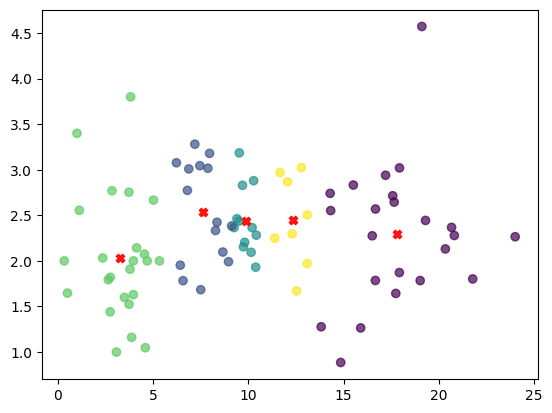

In [ ]:
# put your code here


plt.scatter(point_guards['ppg'], point_guards['atr'], alpha=0.7,  c=point_guards['cluster'], label=point_guards['cluster'], cmap="viridis")
plt.scatter(centroids['ppg'], centroids['atr'], alpha=0.9,  c="Red", marker="X")
plt.show()

### 2.7.2 Setup (continued)

While the **centroids** dataframe object worked well for the initial centroids, where the centroids were just a subset of players, as we iterate the centroids' values will be coordinates that may not match another player's coordinates. Moving forward, **let's use a dictionary object instead to represent the centroids.**

We will need a unique identifier, like **cluster_id**, to refer to each cluster's centroid and a list representation of the centroid's coordinates (or values for **ppg** and **atr**). Let's create a dictionary then with the following mapping:

- key: **cluster_id** of that centroid's cluster
- value: centroid's coordinates expressed as a list ( **ppg** value first, **atr** value second )

To generate the **cluster_ids**, let's iterate through each centroid and assign an integer from 0 to k-1. For example, the first centroid will have a **cluster_id** of 0, while the second one will have a **cluster_id** of 1. We'll write a function, **centroids_to_dict**, that takes in the centroids data frame object, creates a **cluster_id** and converts the **ppg** and **atr** values for that centroid into a list of coordinates, and adds both the **cluster_id** and **coordinates_list** into the dictionary that's returned.



In [ ]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)

### 2.7.3 Step 1 (Euclidean Distance)

Before we can assign players to clusters, we need a way to compare the **ppg** and **atr** values of the players with each cluster's centroids. **Euclidean distance** is the most common technique used in data science for measuring distance between vectors and works extremely well in 2 and 3 dimensions. While in higher dimensions, Euclidean distance can be misleading, in 2 dimensions Euclidean distance is essentially the **Pythagorean theorem**. The formula is :


$$\sqrt{(q_1-p_1)^2+(q_2-p_2)^2+\ldots+(q_n-p_n)^2}$$


where **q** and **p** are the 2 vectors we are comparing. If **q** is **[5, 2]** and **p** is **[3, 1]**, the distance comes out to:

$$\sqrt{(5-3)^2+(2-1)^2} = \sqrt{5} =2.24 $$

Let's create the function **calculate_distance**, which takes in 2 lists (the player's values for **ppg** and **atr** and the centroid's values for **ppg** and **atr**).


In [ ]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0

    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))


2.23606797749979


### 2.7.4 Step 1 (Continued)

Now we need a way to assign data points to clusters based on Euclidean distance. Instead of creating a new variable or data structure to house the clusters, let's keep things simple and just add a column to the **point_guards** data frame that contains the **cluster_id** of the cluster it belongs to.

Note: Even though we don't seed the random numbers to generate the centroids, the answer is seeded and will produce the same results everytime.

In [ ]:
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1

    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)

        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

<ipython-input-27-67b943d06de0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)


### 2.7.5 Visualizing Clusters

Let's write a function, **visualize_clusters**, that we can use to visualize the clusters easily.

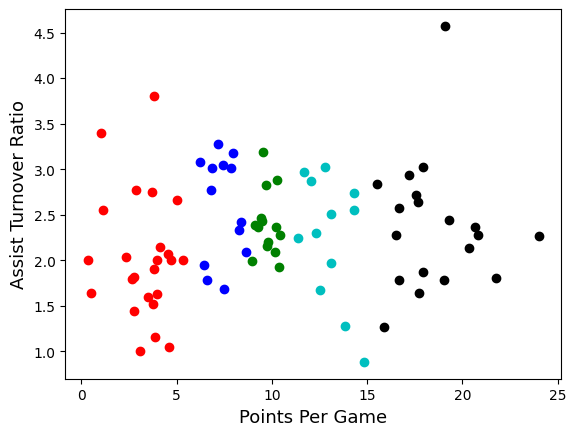

In [ ]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

### 2.7.6 Step 2


How colorful! Now let's code Step 2, where we recalculate the centroids for each cluster.

In [ ]:
def recalculate_centroids(df):
    new_centroids_dict = dict()

    for cluster_id in range(0, num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster
        new_centroid = [np.average(values_in_cluster['ppg']),
                        np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

### 2.7.7 Repeat Step 1

Now that we recalculated the centroids, let's re-run Step 1 (**assign_to_cluster**) and see how the clusters shifted.



<ipython-input-30-13c0029e89e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)


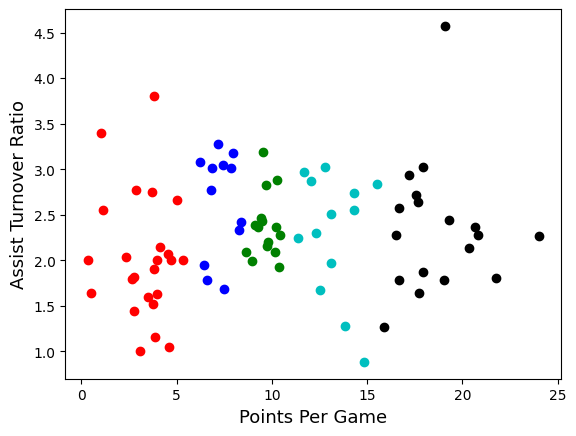

In [ ]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)


### 2.7.8 Repeat Step 2 and Step 1

Now we need to recalculate the centroids, and shift the clusters again.



<ipython-input-31-43fd265c5bb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)


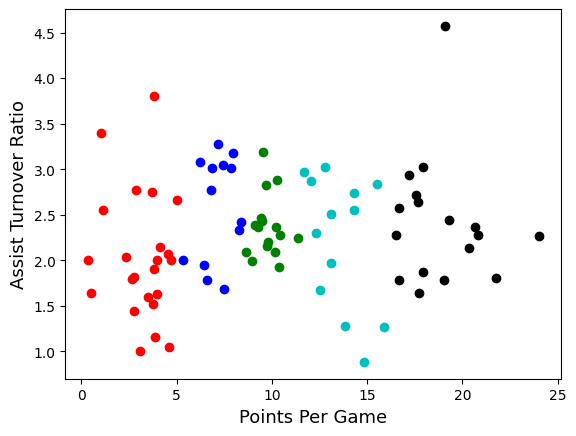

In [ ]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)


## 2.8 Challenges of K-Means

As you repeat Steps 1 and 2 and run **visualize_clusters**, you'll notice that a few of the points are changing clusters between every iteration (especially in areas where 2 clusters almost overlap), but otherwise, the clusters visually look like they don't move a lot after every iteration. This means 2 things:

- K-Means doesn't cause massive changes in the makeup of clusters between iterations, meaning that it will always converge and become stable
- Because K-Means is conservative between iterations, where we pick the initial centroids and how we assign the players to clusters initially matters a lot

To counteract these problems, the **sklearn** implementation of K-Means does some intelligent things like re-running the entire clustering process lots of times with random initial centroids so the final results are a little less biased on one passthrough's initial centroids.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-32-00cb4be4e7f5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_guards['cluster'] = kmeans.labels_


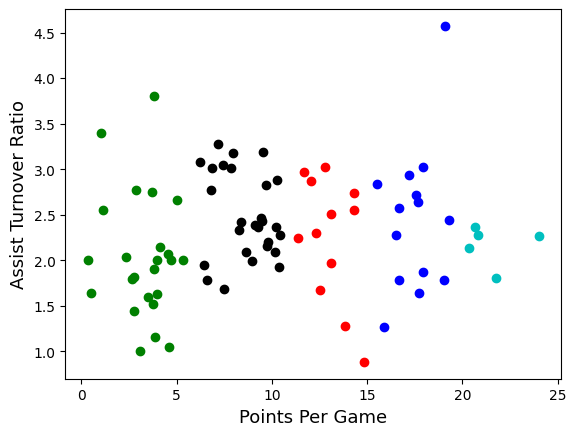

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)


## 2.9 Conclusion

In this lesson, we explored how to segment NBA players into groups with similar traits. Our exploration helped us get a sense of the 5 types of point guards as based on each player's Assist Turnover Ratio and Points Per Game. In future challenges, you can explore how to cluster using many more features, as well as alternative ways of clustering data without using centroids.

We also got to experience the beauty of sklearn and the simplicity of using sophisticated models to get what we need accomplished quickly. In just a few lines, we ran and visualized the results of a robust K-means clustering implementation. When using K-means in the real world, use the sklearn implementation.

# 3.0 Finding the perfect K value using elbow method

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets

# Load the iris dataset
iris = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
# Getting the Statistical Information
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
# Lets check for datatypes
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### Using Pairplots for better understanding of the data points distribution

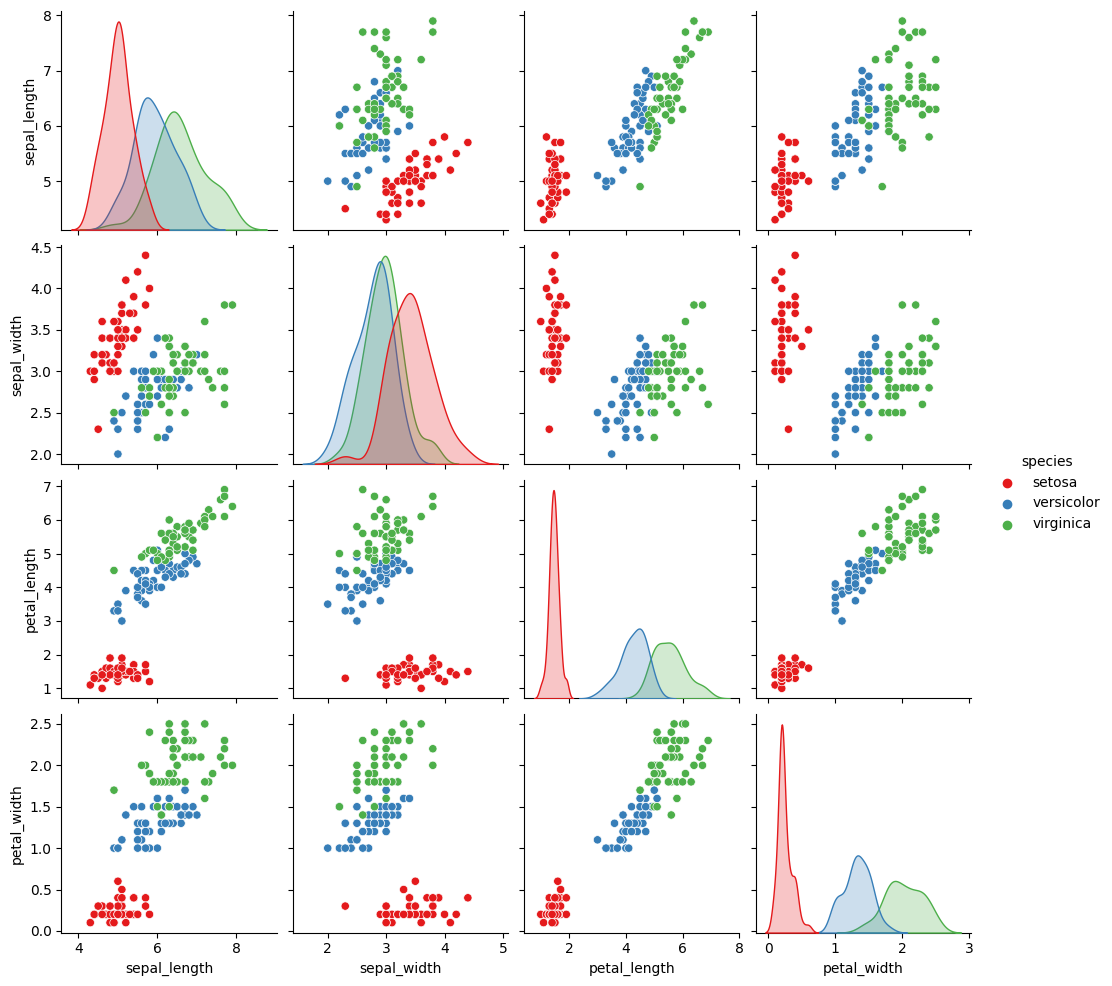

In [ ]:
sns.pairplot(data=iris,hue="species",palette="Set1")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
features = iris.loc[:,["sepal_length","sepal_width","petal_length","petal_width"]]

#### Below snippet shows how we can find the optimum number of clusters for K Means and how can we determine the value of K?

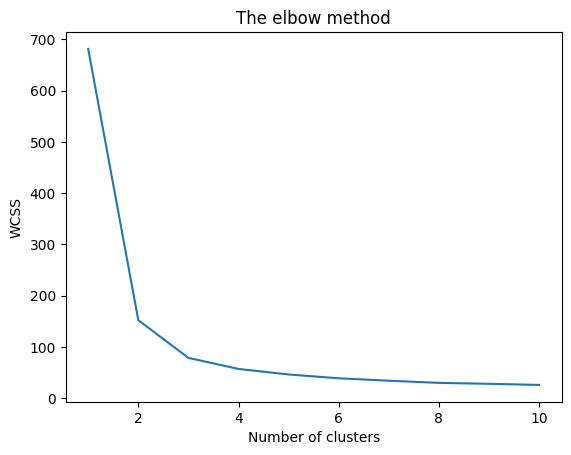

In [ ]:
# Finding the optimum number of clusters for k-means classification

x = iris.iloc[:, [0, 1, 2, 3]].values

from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph,
# `allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') # Within cluster sum of squares
plt.show()

We can clearly see why it is called 'The elbow method' from the above graph, the optimum clusters is where the elbow occurs. This is when the within cluster sum of squares (WCSS) doesn't decrease significantly with every iteration.

From this we choose the number of clusters as **3**.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


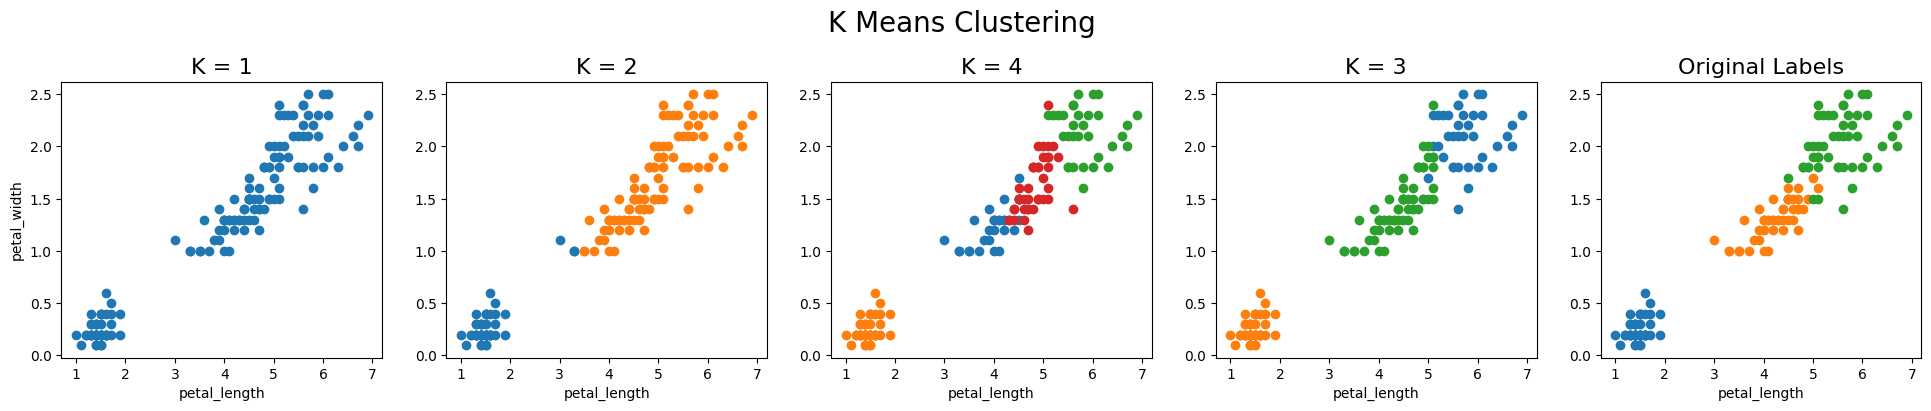

In [ ]:
plt.figure(figsize=(24,4))

plt.suptitle("K Means Clustering",fontsize=20)


plt.subplot(1,5,1)
plt.title("K = 1",fontsize=16)
plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.scatter(features.petal_length,features.petal_width)


plt.subplot(1,5,2)
plt.title("K = 2",fontsize=16)
plt.xlabel("petal_length")
kmeans = KMeans(n_clusters=2)
features["labels"] = kmeans.fit_predict(features)
plt.scatter(features.petal_length[features.labels == 0],features.petal_width[features.labels == 0])
plt.scatter(features.petal_length[features.labels == 1],features.petal_width[features.labels == 1])

# dropping labels we only want to use features.
features.drop(["labels"],axis=1,inplace=True)

plt.subplot(1,5,4)
plt.title("K = 3",fontsize=16)
plt.xlabel("petal_length")
kmeans = KMeans(n_clusters=3)
features["labels"] = kmeans.fit_predict(features)
plt.scatter(features.petal_length[features.labels == 0],features.petal_width[features.labels == 0])
plt.scatter(features.petal_length[features.labels == 1],features.petal_width[features.labels == 1])
plt.scatter(features.petal_length[features.labels == 2],features.petal_width[features.labels == 2])

# dropping labels as we only want to use features.
features.drop(["labels"],axis=1,inplace=True)

plt.subplot(1,5,3)
plt.title("K = 4",fontsize=16)
plt.xlabel("petal_length")
kmeans = KMeans(n_clusters=4)
features["labels"] = kmeans.fit_predict(features)
plt.scatter(features.petal_length[features.labels == 0],features.petal_width[features.labels == 0])
plt.scatter(features.petal_length[features.labels == 1],features.petal_width[features.labels == 1])
plt.scatter(features.petal_length[features.labels == 2],features.petal_width[features.labels == 2])
plt.scatter(features.petal_length[features.labels == 3],features.petal_width[features.labels == 3])

# dropping labels as we only want to use features.
features.drop(["labels"],axis=1,inplace=True)

plt.subplot(1,5,5)
plt.title("Original Labels",fontsize=16)
plt.xlabel("petal_length")
plt.scatter(iris.petal_length[iris.species == "setosa"],iris.petal_width[iris.species == "setosa"])
plt.scatter(iris.petal_length[iris.species == "versicolor"],iris.petal_width[iris.species == "versicolor"])
plt.scatter(iris.petal_length[iris.species == "virginica"],iris.petal_width[iris.species == "virginica"])

plt.subplots_adjust(top=0.8)
plt.show()

In [ ]:
# Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = 3, init = 'k-means++',
                max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)

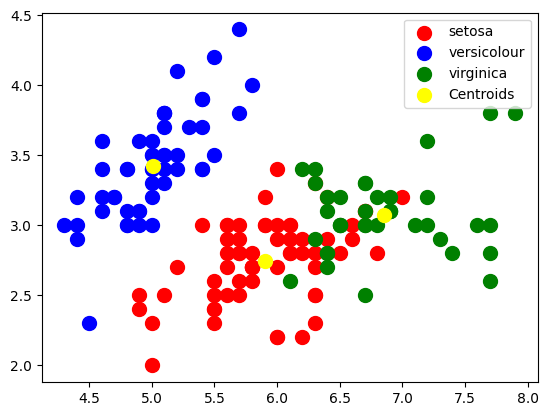

In [ ]:
# Visualising the clusters - On the first two columns
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1],
            s = 100, c = 'red', label = 'setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1],
            s = 100, c = 'blue', label = 'versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1],
            s = 100, c = 'green', label = 'virginica')

# Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1],
            s = 100, c = 'yellow', label = 'Centroids')

plt.legend()

## 3.2 Silhouette Analysis

This tutorial is available here: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5662344175321901
For n_clusters = 6 The average silhouette_score is : 0.4358297989156284


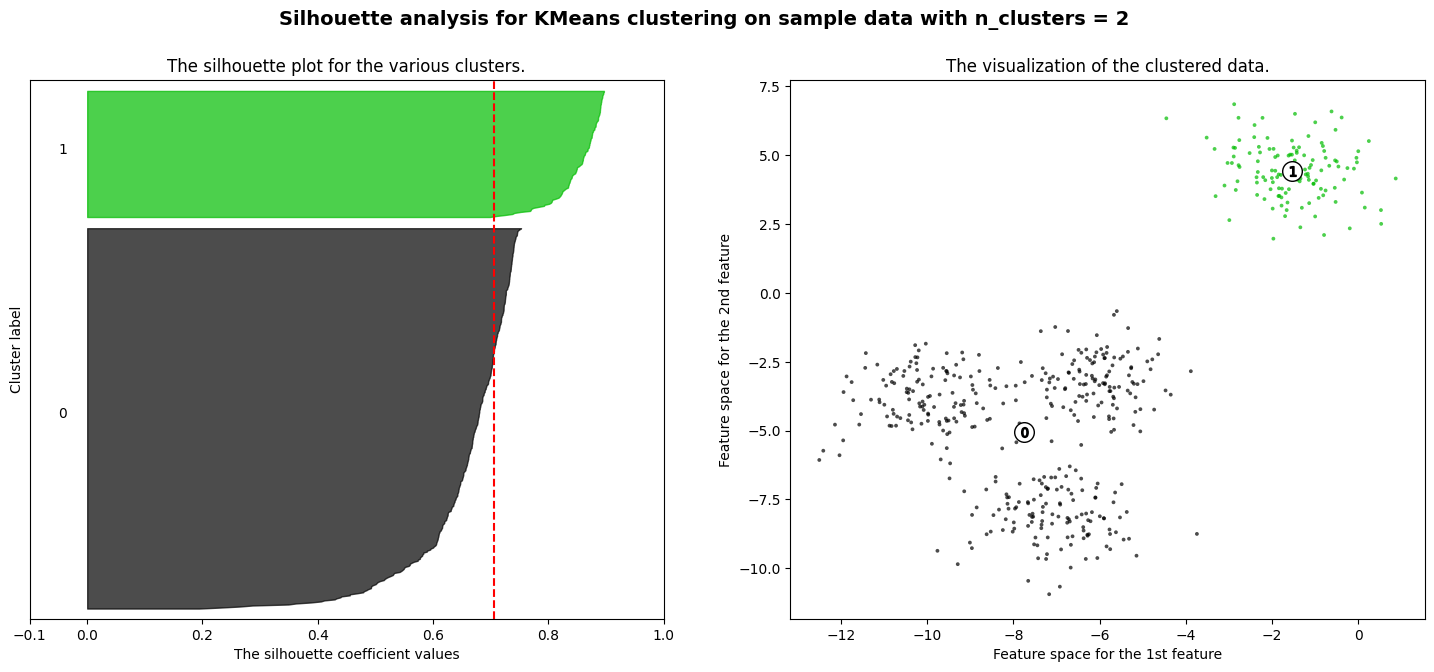

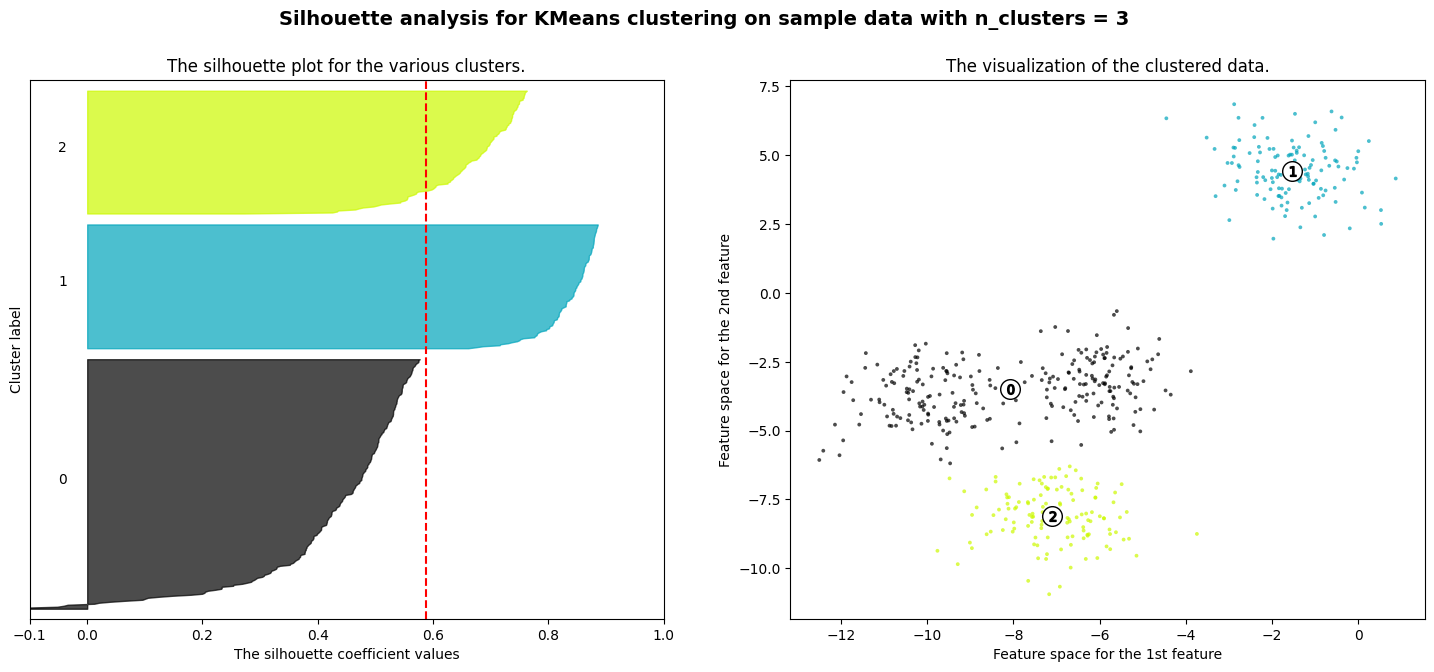

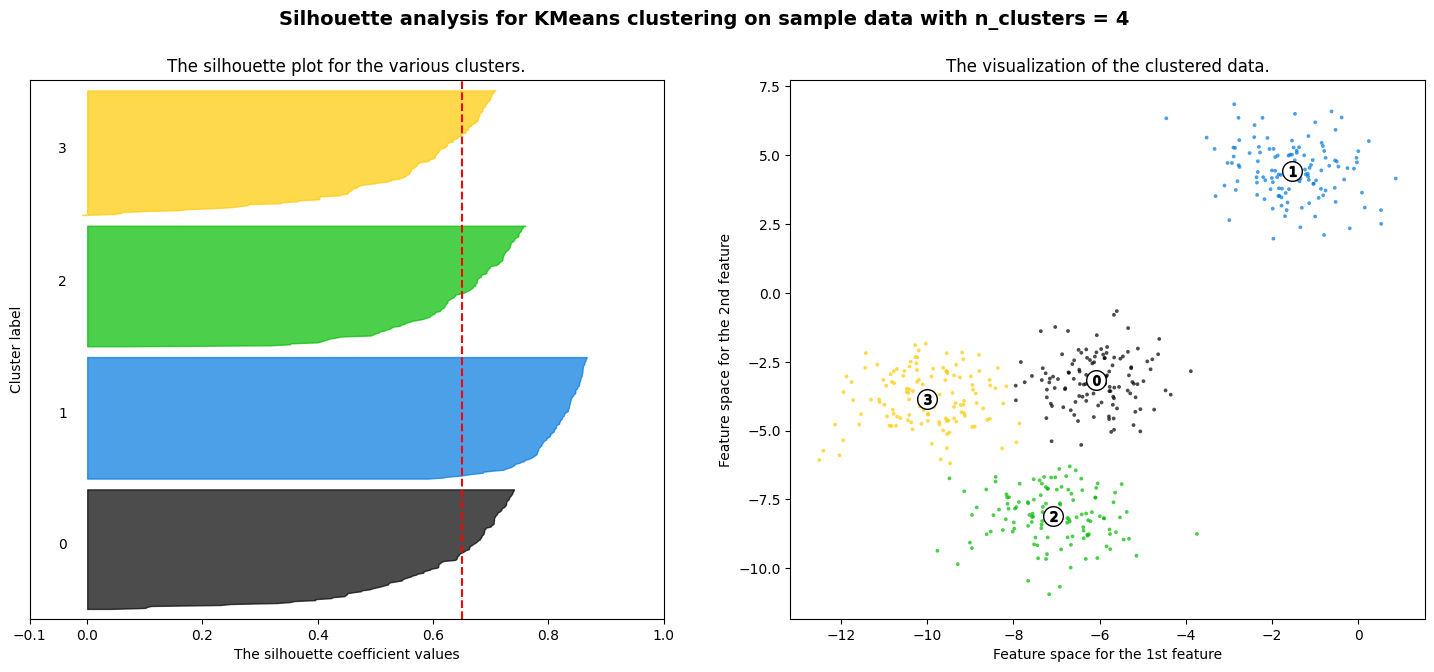

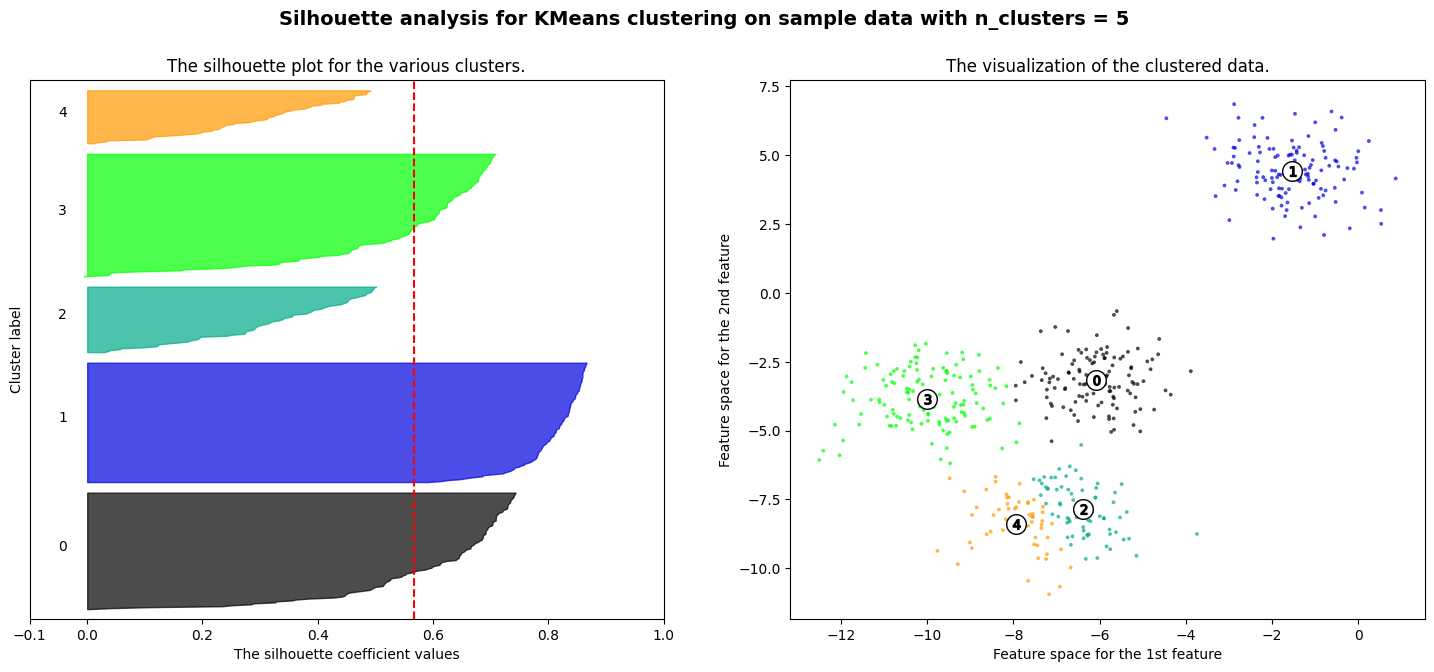

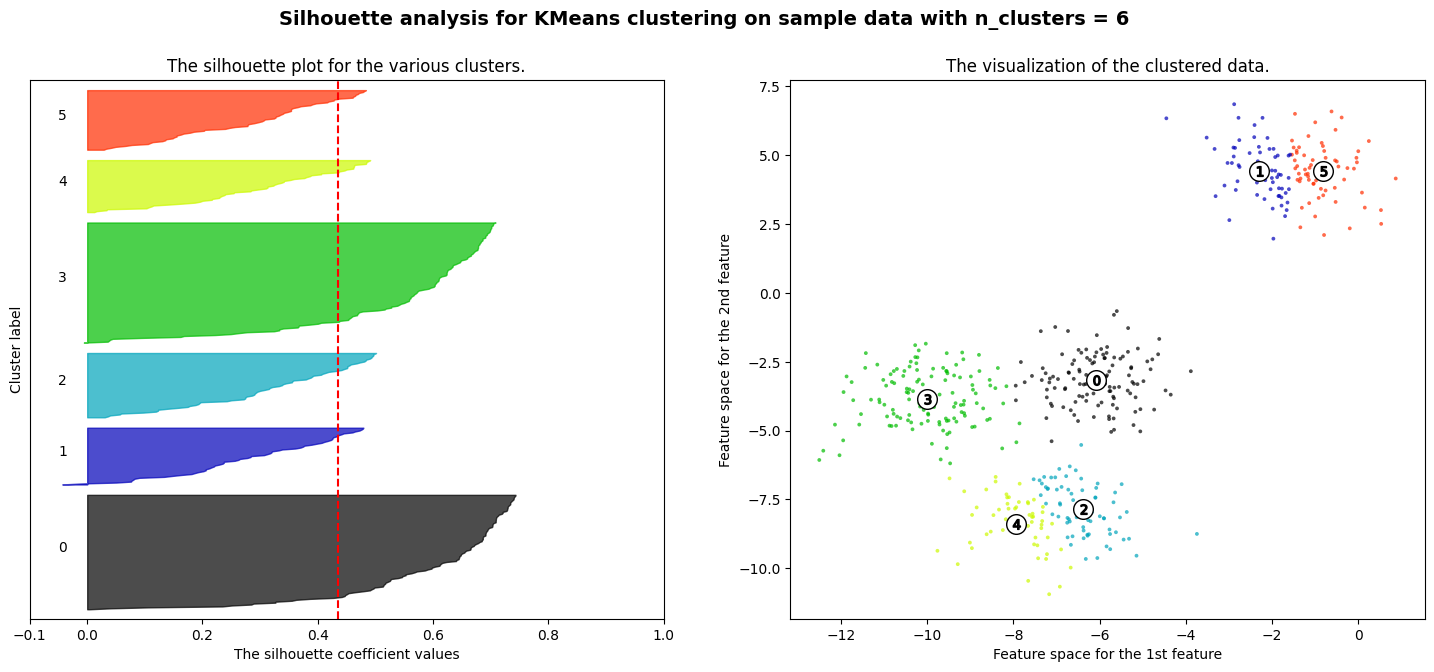

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6810461692117465
For n_clusters = 3 The average silhouette_score is : 0.5511916046195927
For n_clusters = 4 The average silhouette_score is : 0.4974551890173758
For n_clusters = 5 The average silhouette_score is : 0.44283510635612855
For n_clusters = 6 The average silhouette_score is : 0.45648535112758215


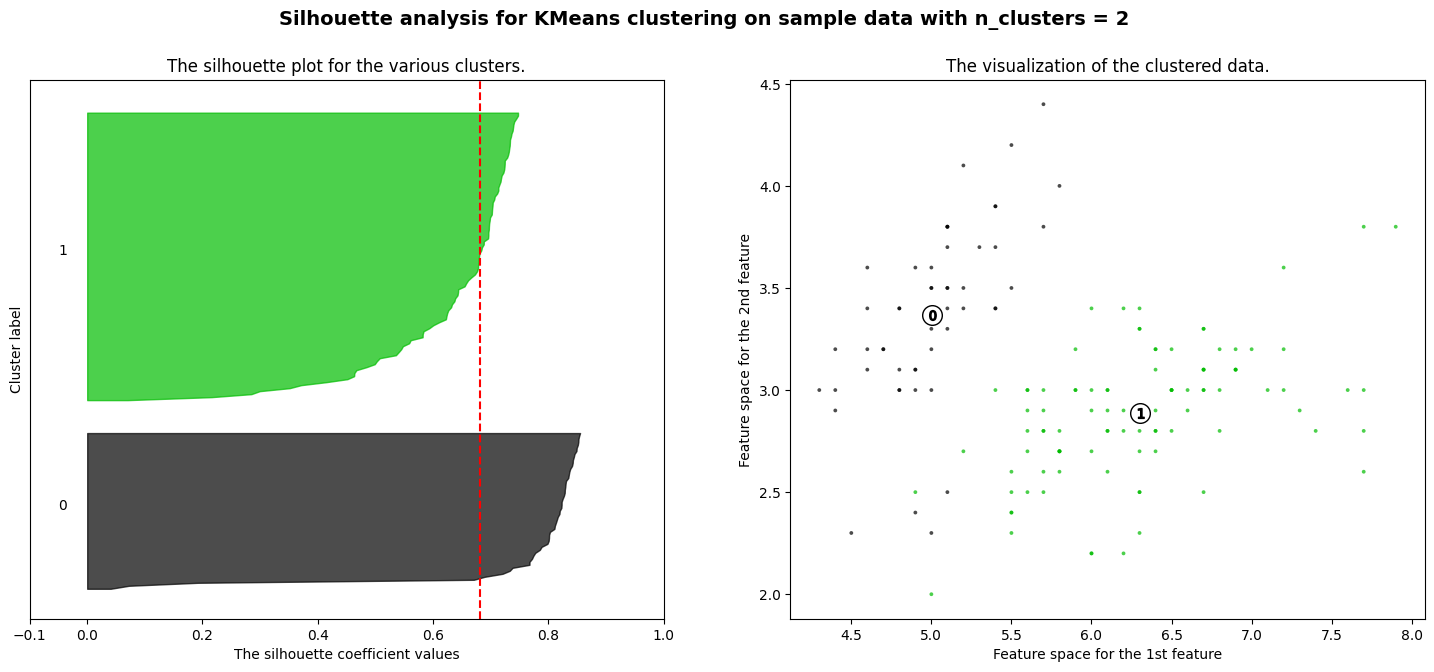

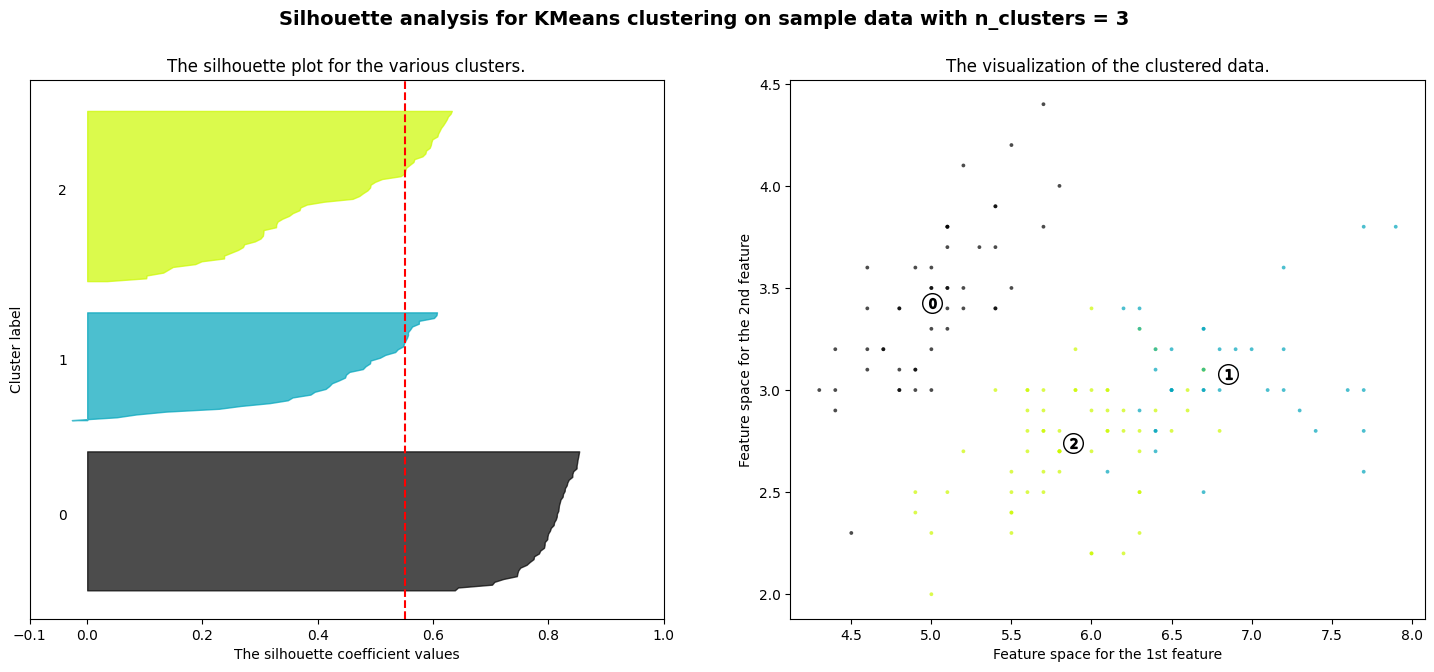

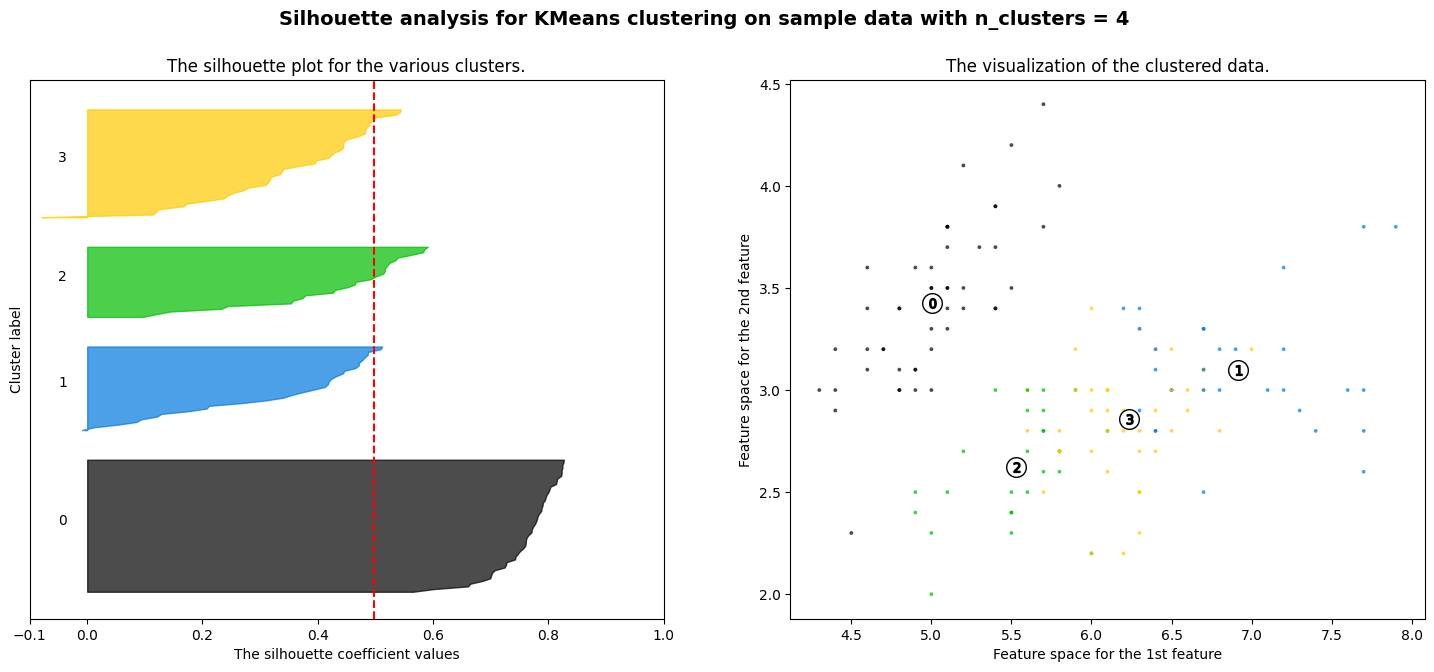

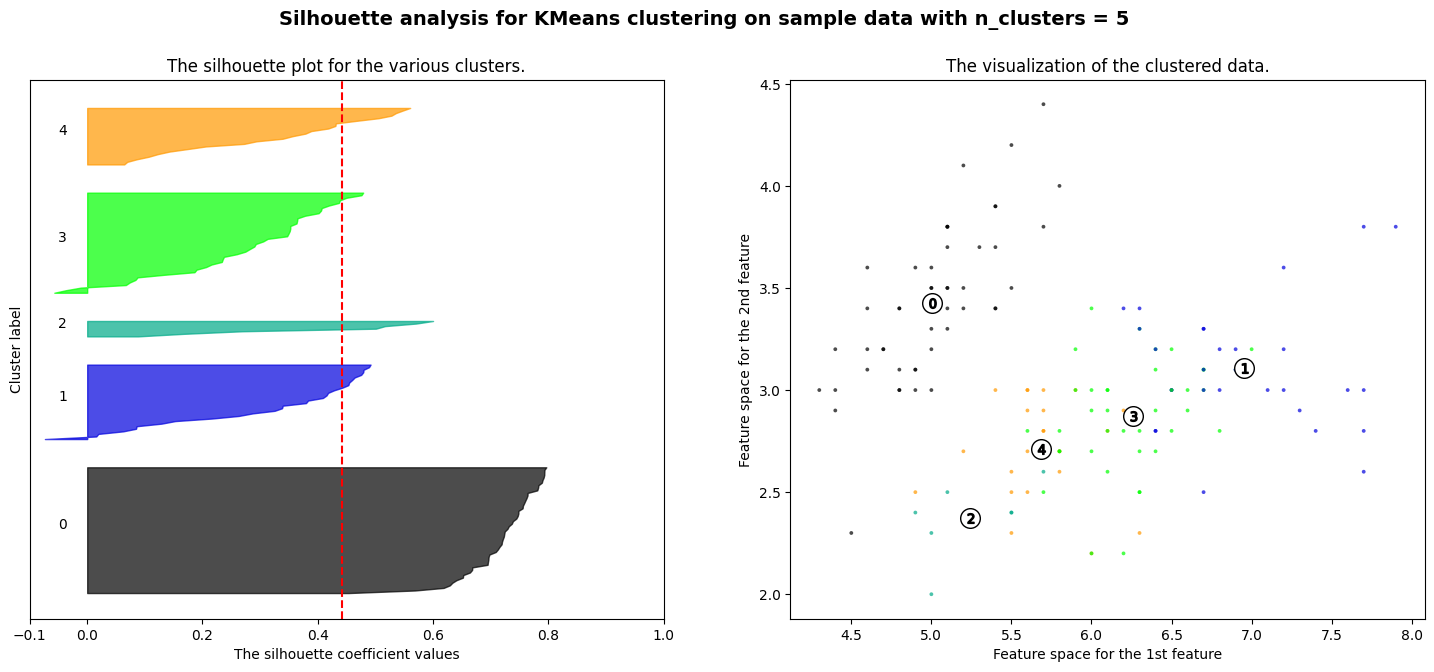

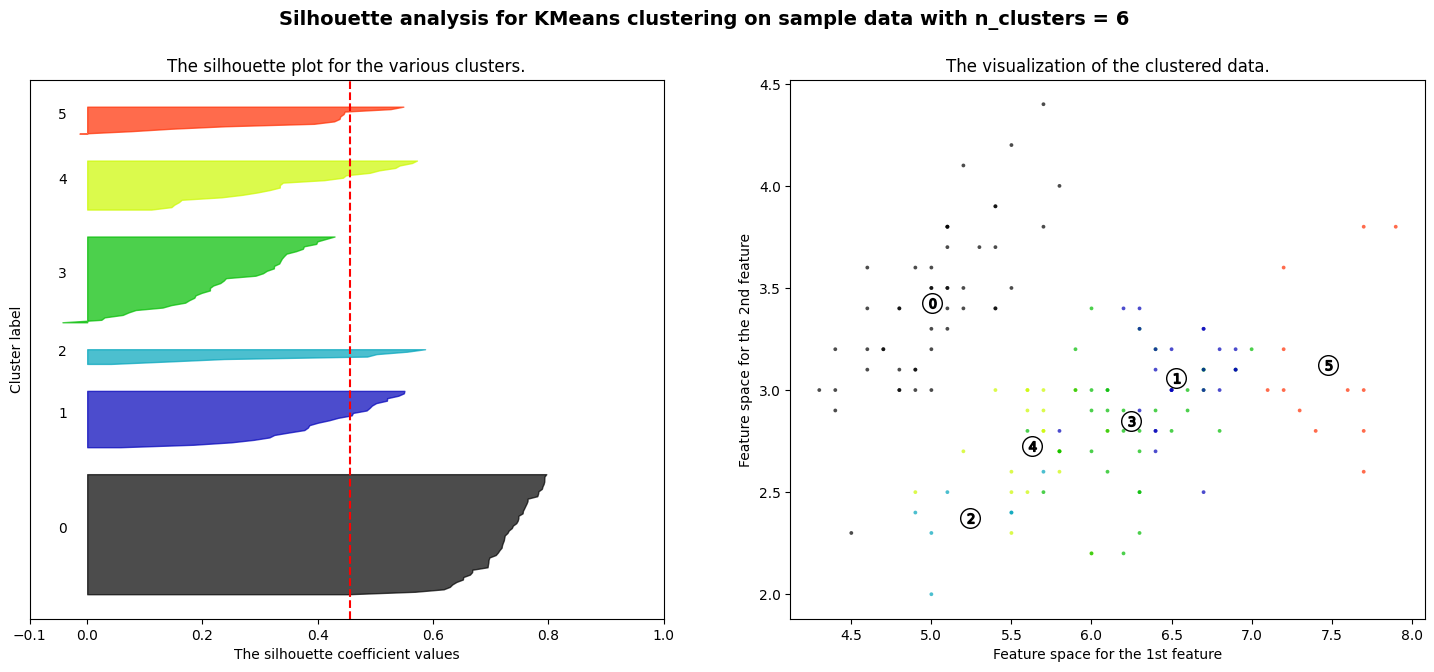

In [ ]:
X = iris.iloc[:, [0, 1, 2, 3]].values

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# 4.0 Fuzzy c-means clustering

Os princípios da lógica difusa podem ser usados para agrupar dados multidimensionais, atribuindo a cada ponto uma associação em cada centro de agrupamento de 0 a 100 por cento. Isso pode ser muito poderoso em comparação com o agrupamento tradicional com limites rígidos, onde cada ponto recebe um rótulo nítido e exato.

O agrupamento fuzzy c-means é realizado via `skfuzzy.cmeans`, e a saída desta função pode ser reaproveitada para classificar novos dados de acordo com os clusters calculados (também conhecidos como previsão) via `skfuzzy.cmeans_predict`

### 4.2 Geração e configuração de dados

Neste exemplo, primeiro realizaremos as importações necessárias e, em seguida, definiremos alguns dados de teste com os quais trabalhar.

In [ ]:
# Instalando 2 bibliotecas que vamos precisar
#!pip install networkx
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=c0722dfdf2f034daddc58cc4a8b20e7df8d467bab5249ae87f15397e1017efa6
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy




```
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Defina três centros de cluster
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Defina três sigmas de cluster em x e y, respectivamente
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Gerar dados de teste
np.random.seed(42)  # Defina uma seed para reprodutibilidade
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize os dados de teste
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Dados de teste: 200 pontos em x3 clusters.')
```



## 4.1 Agrupamento

Acima estão nossos dados de teste. Vemos três bolhas distintas. No entanto, o que aconteceria se não soubéssemos quantos clusters devemos esperar? Talvez se os dados não estivessem tão claramente agrupados?

Vamos tentar agrupar nossos dados várias vezes, com entre 2 e 9 clusters.

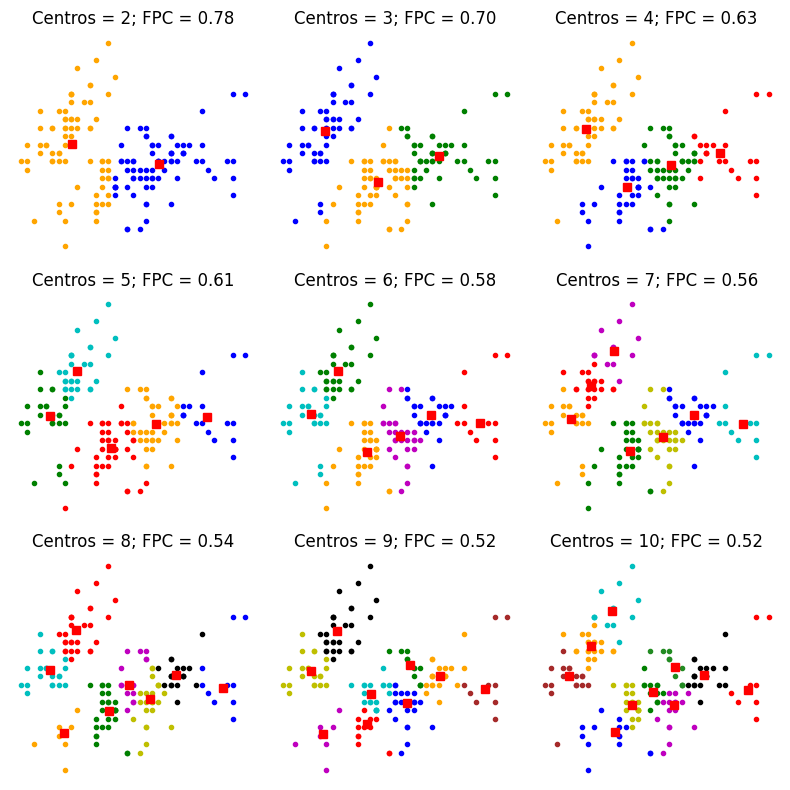

In [ ]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt


colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Configure o loop e plota
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
xpts = X[:, 0]
ypts = X[:, 1]
alldata = np.vstack((xpts, ypts))
fpcs = [] # fuzzy partition coefficient (FPC)

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Armazena valores fpc
    fpcs.append(fpc)

    # Plota clusters atribuídos, para cada ponto de dados no conjunto de treinamento
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Marque o centro de cada cluster difuso
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centros = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

## 4.2 The fuzzy partition coefficient (FPC)

O FPC é definido no intervalo de 0 a 1, sendo 1 o melhor. É uma métrica que nos diz com que clareza nossos dados são descritos por um determinado modelo. Em seguida, agruparemos nosso conjunto de dados - que sabemos ter três clusters - várias vezes, com entre 2 e 9 clusters.

Em seguida, mostraremos os resultados do agrupamento e traçaremos o coeficiente de partição fuzzy. Quando o FPC é maximizado, nossos dados são melhor descritos.

Text(0, 0.5, 'Fuzzy partition coefficient')

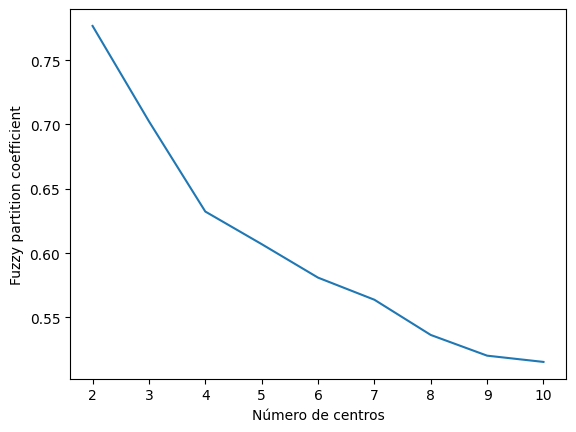

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Número de centros")
ax2.set_ylabel("Fuzzy partition coefficient")

Como podemos ver, o número ideal de centros é 3. Isso não é novidade para nosso exemplo artificial, mas ter o FPC disponível pode ser muito útil quando a estrutura de seus dados não é clara.

Observe que começamos com dois centros, não um; agrupar um conjunto de dados com apenas um centro de cluster é a solução trivial e, por definição, retornará FPC == 1.

## 4.3 Classificação de novos dados

Agora que podemos agrupar os dados, a próxima etapa geralmente é encaixar novos pontos em um modelo existente. Isso é conhecido como previsão. Requer um modelo existente e novos dados para serem classificados.

### Construindo o modelo

Sabemos que nosso melhor modelo tem três centros de cluster. Vamos reconstruir um modelo de 3 clusters para uso na previsão, gerar novos dados uniformes e prever a qual cluster cada novo ponto de dados pertence.

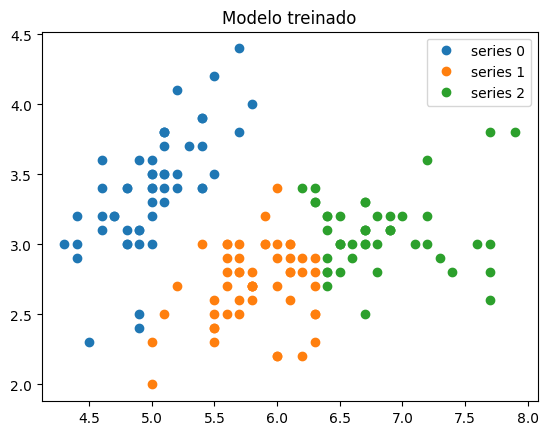

In [ ]:
# Geração de novo modelo fuzzy com 3 centros de cluster -
# note que a ordenação do centro é aleatório neste algoritmo de agrupamento,
# então os centros podem mudar de lugar
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# Exibir modelo de 3 clusters
fig2, ax2 = plt.subplots()
ax2.set_title('Modelo treinado')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()



Por fim, geramos dados amostrados uniformemente sobre esse campo e os classificamos via `cmeans_predict`, incorporando-os ao modelo pré-existente.

In [ ]:
# Gera dados amostrados uniformemente espalhados pelo intervalo [0, 10] em x e y
newdata = np.random.uniform(0, 1, (1100, 2)) * 10


In [ ]:
# Predição de novos membros do cluster com `cmeans_predict`,
# bem como `cntr` do modelo de 3 clusters
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(newdata.T,
                                                   cntr, 2,
                                                   error=0.005,
                                                   maxiter=1000)

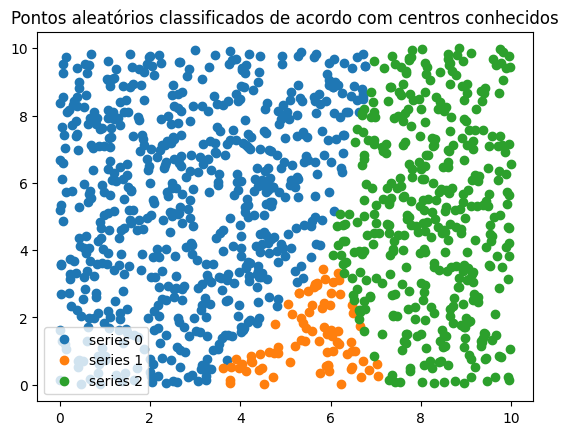

In [ ]:
# Plote os dados uniformes classificados. Observe para visualização o máximo
# valor de associação foi obtido em cada ponto (ou seja, eles são endurecidos,
# resultados não fuzzy visualizados), mas o resultado fuzzy completo é a saída
# de cmeans_predict.
cluster_membership = np.argmax(u, axis=0) # Hardening/Endurecimento para visualização

fig3, ax3 = plt.subplots()
ax3.set_title('Pontos aleatórios classificados de acordo com centros conhecidos')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()


# 5.0 Autoencoder on Iris Dataset

This tutorial is avalable at: https://github.com/orico/PCAvsAutoencoder

In this tutorial I will explain about the relation between PCA and an Autoencoder (AE). I assume that you have a basic grasp of what PCA and AE are, but if you are not familiar PCA or autoencoders please read [1,2].

A lot have been written about using a linearly activated autoencoder (AE) to approximate principal component analysis (PCA). From a math point of view, minimizing the reconstruction error in PCA is the same as AE [3].

However, why limit ourselves to linear transformations? Neural nets are very flexible, therefore we can introduce non-linearities by using non-linear activation functions [4]. Additionally, with an increasing amount of features, PCA will result in slower processing compared with an AE. Our Hypothesis is that the subspace spanned by the AE will be similar to the one found by PCA [5].

In this study we'll see the similarities and differences between PCA, a linear and non-linear autoencoders. Please note that a non-linear AE will be non-linear except when the input data is spanned linearly.


In [ ]:
import keras
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import Adam
from keras import regularizers
from sklearn import datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

%matplotlib inline

RANDOM_SEED = 37117
np.random.seed(RANDOM_SEED)

Using TensorFlow backend.


First, lets load up the Iris data-set and scale it between [0,1].

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
def plot3clusters(X, title, vtitle):
  plt.figure()
  colors = ['navy', 'turquoise', 'darkorange']
  lw = 2

  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=1., lw=lw,
                  label=target_name)
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)
  plt.xlabel(vtitle + "1")
  plt.ylabel(vtitle + "2")
  plt.show()

Then we use the data-set to fit a PCA and plot the first two PCs against each other. We can see that two big blobs emerge, using the target labels we can see how the three clusters are contained within those two blobs.

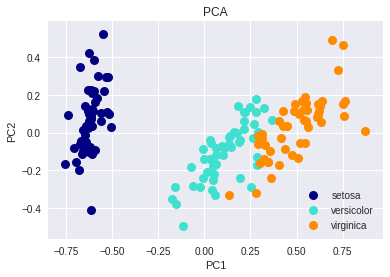

In [ ]:
pca = decomposition.PCA()
pca_transformed = pca.fit_transform(X_scaled)
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')

Our first network is a linear AE that has 3 layers (encoding, hidden and decoding), the encoding and decoding layers have 'linear activations' and the hidden layer has two neurons. Essentially this structure approximates PCA by reducing the data from four features to two features in the hidden layer. As you can see the model converges quite nicely and our validation loss has dropped to zero. After passing the training data through the hidden layer we get two new vectors and by plotting them against each other we clearly blob and cluster formation similar to PCA.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


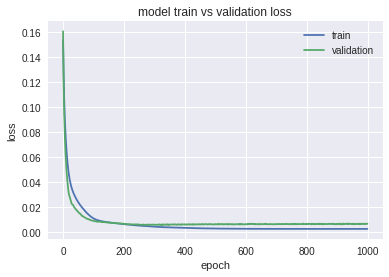

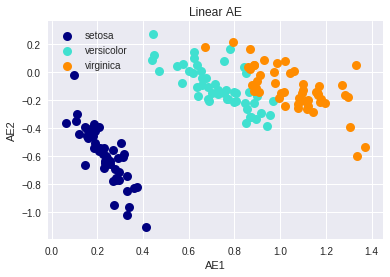

In [ ]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim = X_scaled.shape[1]
encoding_dim = 2
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X_scaled)

plot3clusters(encoded_data[:,:2], 'Linear AE', 'AE')


In [ ]:
labels_true = y
titles = ['PCA', 'Linear AE']
for n_clusters_ in [2]:
  estimators = [('PCA'    , KMeans(n_clusters=n_clusters_), pca_transformed),
                ('AE linear' , KMeans(n_clusters=n_clusters_), encoded_data)]

  print(type(y))
  for name, est, data in estimators:
      X = data
      est.fit(X)
      labels = est.labels_
      print(name,':')
      print(labels[:])
      print('Estimated number of clusters: %d' % n_clusters_)
      print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
      print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
      print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
      print("Adjusted Rand Index: %0.3f"
            % metrics.adjusted_rand_score(labels_true, labels))
      print("Adjusted Mutual Information: %0.3f"
            % metrics.adjusted_mutual_info_score(labels_true, labels))
      print("Silhouette Coefficient: %0.3f"
            % metrics.silhouette_score(X, labels))
      print()
  print()
  print('----------------------------------------------------------------------------------')
  print()

<class 'numpy.ndarray'>
PCA :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Estimated number of clusters: 2
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.577
Silhouette Coefficient: 0.629

AE linear :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Estimated number of clusters: 2
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.577
Silhouette Coef

Lets create a second AE, this time we'll replace both linear activation functions with a sigmoid. This network structure can be thought of PCA with non-linear transformation and similarly to the one above it converges to a local minimum and we can plot the resulting dense-vectors.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


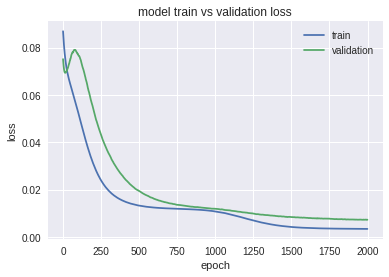

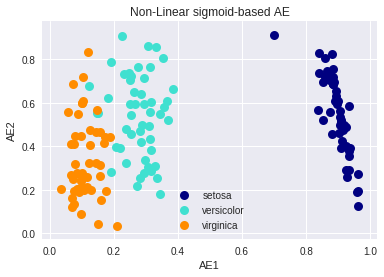

In [ ]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim2 = X_scaled.shape[1]
encoding_dim2 = 2
input_img2 = Input(shape=(input_dim2,))
encoded2 = Dense(encoding_dim2, activation='sigmoid')(input_img2)
decoded2 = Dense(input_dim2, activation='sigmoid')(encoded2)
autoencoder2 = Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mse')
print(autoencoder2.summary())

history2 = autoencoder2.fit(X_scaled, X_scaled,
                epochs=2000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder2 = Model(input_img2, encoded2)
encoded_input2 = Input(shape=(encoding_dim2,))
decoder_layer2 = autoencoder2.layers[-1]
decoder2 = Model(encoded_input2, decoder_layer2(encoded_input2))
encoded_data2 = encoder2.predict(X_scaled)

plot3clusters(encoded_data2[:,:2], 'Non-Linear sigmoid-based AE', 'AE')


Our last AE uses relu activation with an L1 regularizer. It is another way of saying that we want to approximate PCA by using a non-linear AE with constrained representations [2]. Similarly to the Previous networks it converges to a local minimum and both dense-vectors show three clusters contained in two blobs.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 12        
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
None


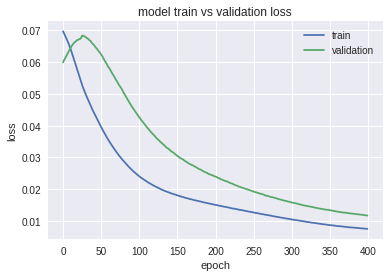

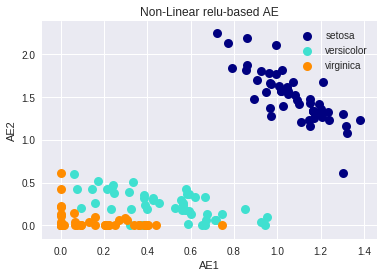

In [ ]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim3 = X_scaled.shape[1]
encoding_dim3 = 2
input_img3 = Input(shape=(input_dim3,))
encoded3 = Dense(encoding_dim3, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img3)
decoded3 = Dense(input_dim3, activation='sigmoid')(encoded3)
autoencoder3 = Model(input_img3, decoded3)
autoencoder3.compile(optimizer='adam', loss='mse')
print(autoencoder3.summary())

history3 = autoencoder3.fit(X_scaled, X_scaled,
                epochs=400,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# use our encoded layer to encode the training input
encoder3 = Model(input_img3, encoded3)
encoded_input3 = Input(shape=(encoding_dim3,))
decoder_layer3 = autoencoder3.layers[-1]
decoder3 = Model(encoded_input3, decoder_layer3(encoded_input3))
encoded_data3 = encoder3.predict(X_scaled)

plot3clusters(encoded_data3[:,:2], 'Non-Linear relu-based AE', 'AE')


After training all 3 autoencoders and pushing our training data through the hidden layer, we compare the first 2 PCs and the AE’s dense features. We can clearly see that the figures in these vectors are not the same, across all models. This is very clear from plotting each two vectors and looking at the resulting clusters. Next we would like to compare how a simple KMEANS with 2 and 3 clusters classifies the data.

In [ ]:
print('PCA\n',pca_transformed[:,0:2][0:10])
print()
print('Linear AE\n',encoded_data[0:10])
print()
print('Nonlinear AE with sigmoid\n',encoded_data2[0:10])
print()
print('Nonlinear AE with relu\n',encoded_data3[0:10])


PCA
 [[-0.63036125  0.11155626]
 [-0.62354631 -0.1003132 ]
 [-0.6697928  -0.04722006]
 [-0.65463305 -0.09879127]
 [-0.64826327  0.13755769]
 [-0.534057    0.29322304]
 [-0.65639589  0.01492194]
 [-0.62564396  0.06107532]
 [-0.67652584 -0.19648232]
 [-0.64613717 -0.06324223]]

Linear AE
 [[ 0.23598923 -0.6469984 ]
 [ 0.1800067  -0.39132446]
 [ 0.15926996 -0.4707053 ]
 [ 0.15585978 -0.40266344]
 [ 0.22946599 -0.6839787 ]
 [ 0.35961363 -0.82653046]
 [ 0.18559463 -0.53790534]
 [ 0.2248888  -0.58437693]
 [ 0.11058816 -0.2936817 ]
 [ 0.17480673 -0.44444498]]

Nonlinear AE with sigmoid
 [[0.91792077 0.4988284 ]
 [0.85968477 0.71589184]
 [0.88740337 0.6970919 ]
 [0.86628693 0.7467765 ]
 [0.9257194  0.487611  ]
 [0.92530775 0.28976613]
 [0.89203835 0.6544596 ]
 [0.9049678  0.5603036 ]
 [0.83925694 0.82819325]
 [0.88463604 0.6867349 ]]

Nonlinear AE with relu
 [[1.0436548 1.617722 ]
 [1.1459521 1.2238551]
 [1.2010672 1.3515487]
 [1.2407831 1.2337388]
 [1.0709138 1.6741986]
 [0.8564586 1.8071246]

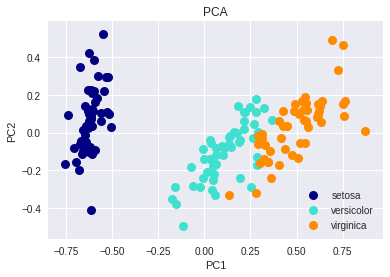

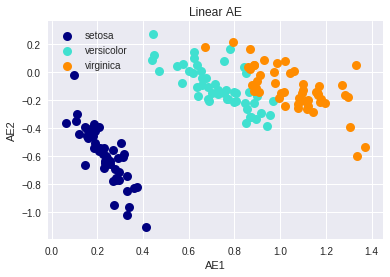

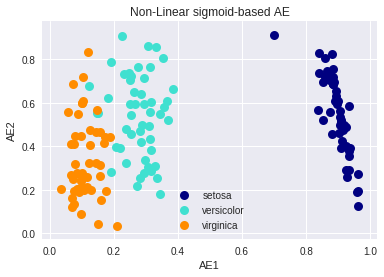

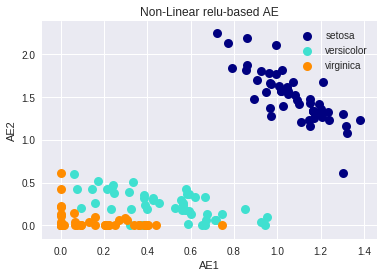

In [ ]:
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')
plot3clusters(encoded_data[:,:2], 'Linear AE', 'AE')
plot3clusters(encoded_data2[:,:2], 'Non-Linear sigmoid-based AE', 'AE')
plot3clusters(encoded_data3[:,:2], 'Non-Linear relu-based AE', 'AE')

We would like to know if each result, clustered with KMEANS (k=2 & 3), can label the data similarly across all models, even if the dense range is very different. The following is a printed classification vector and metrics for the samples in the training set. The printed output and metrics show, that using different dense representation that were created by different algorithms, two identical or three very similar clusters can be found. We can see that the metric scores are mostly identical when clustering the two blobs and the metric figures are very close when clustering for the three known flower classes.
Please note that minor differences can happen due to the random nature of neural networks.

In [ ]:
labels_true = y
titles = ['PCA', 'Linear AE', 'Sigmoid AE', 'Relu AE']
for n_clusters_ in [2,3]:
  estimators = [('PCA'    , KMeans(n_clusters=n_clusters_), pca_transformed),
                ('AE linear' , KMeans(n_clusters=n_clusters_), encoded_data),
                ('AE sigmoid' , KMeans(n_clusters=n_clusters_), encoded_data2),
                ('AE relu', KMeans(n_clusters=n_clusters_), encoded_data3)]

  print('Number of clusters: %d' % n_clusters_)
  for name, est, data in estimators:
      X = data
      est.fit(X)
      labels = est.labels_
      print(name,':')
      print(labels[:])
      print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
      print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
      print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
      print("Adjusted Rand Index: %0.3f"
            % metrics.adjusted_rand_score(labels_true, labels))
      print("Adjusted Mutual Information: %0.3f"
            % metrics.adjusted_mutual_info_score(labels_true, labels))
      print("Silhouette Coefficient: %0.3f"
            % metrics.silhouette_score(X, labels))
      print()
  print()
  print('----------------------------------------------------------------------------------')
  print()

Number of clusters: 2
PCA :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.577
Silhouette Coefficient: 0.629

AE linear :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
Homogeneity: 0.579
Completeness: 1.000
V-measure: 0.734
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.577
Silhouette Coefficient: 0.647

AE sigmoid :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

I would like to thank Natanel Davidovits and Gal Yona for their invaluable critique, proof-reading and comments.

Ori Cohen has done his PhD in computer science in the fields of machine learning, brain-computer-interface and neurobiology.

References:

[1] [building AE in keras](https://blog.keras.io/building-autoencoders-in-keras.html)

[2] [PCA in 3 steps using Iris](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)

[3] [CSC 411: Lecture 14: Principal Components Analysis &
Autoencoders](https://www.cs.toronto.edu/~urtasun/courses/CSC411/14_pca.pdf), page 16.

[4] [A Tutorial on Autoencoders for Deep Learning](https://lazyprogrammer.me/a-tutorial-on-autoencoders/)

[5] [what are the differences between pca and autoencoder](https://stats.stackexchange.com/questions/120080/whatre-the-differences-between-pca-and-autoencoder)